# Miniproyecto : Machine Learning con Valor

# Pauta de Evaluación

Este MP está enfocado en responder preguntas de negocio relevantes para **AMAZOFF**.

### Preguntas de Negocio

1. El equipo necesita extraer la máxima información de los datos. ¿Cómo modificarías la base de datos para ser usada con modelos de ML?
2. ¡Wow! Gran *feature engineering*. Toca armar tu set para entrenar el modelo. ¿Podrías generar gráficas para el equipo de Customer Experience que expliquen mejor los datos nuevos? ¡No olvides explicarlas!
3. Dicen que se pueden encontrar patrones en tus datos de entrenamiento. ¿Qué patrones encuentras en los pedidos? ¿Cómo pueden ser de utilidad para mejorar las ventas de AMAZOFF?
4. ¡Viva el ML! Toca predecir la satisfacción del cliente. ¿Es posible predecir bien el `rating_class`?
5. El equipo de Customer Experience dice que un solo modelo no es suficiente. ¿Podrías implementar otro?
6. ¡Dos modelos! Eso es genial. ¿Qué modelo funcionó peor? ¿Si utilizas PCA podría mejor?


# Preámbulo


In [5]:
# Association Rules
from mlxtend.frequent_patterns import apriori, association_rules

# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# General Data Science
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [6]:
# Esta configuración permite que los dataframes se muestren completos.
pd.set_option('display.max_columns', None)

In [7]:
# PARÁMETROS

DATA_PATH = ('ecommerce.csv') # Si tienes el archivo en otro lugar, cámbialo.
RANDOM_STATE = 0 # ¡Cámbialo a tu número favorito!

In [8]:
# Esta celda se encarga de cargar los datos.
df = pd.read_csv(DATA_PATH)
df.purchased = pd.to_datetime(df.purchased)
df.delivered = pd.to_datetime(df.delivered)
df.estimated_delivery = pd.to_datetime(df.estimated_delivery)
print(f'{df.shape[0]} rows x {df.shape[1]} columns')
df.head(5)

63606 rows x 14 columns


,order,product,seller,customer,city,state,category,price,shipping,payment,purchased,delivered,estimated_delivery,rating
0,0,0,0,0,unknown,SP,health,223.51,84.65,credit card,2017-10-22 18:57:54,2017-10-26 22:19:52,2017-11-09 12:00:00,1.0
1,1,1,1,1,unknown,RJ,health,170.80,23.79,credit card,2018-06-20 21:40:31,2018-07-03 22:51:22,2018-07-24 12:00:00,4.5
2,2,2,2,2,unknown,SP,technology,64.40,17.38,credit card,2018-02-16 16:19:31,2018-02-27 01:29:50,2018-03-08 12:00:00,3.5
3,3,1,3,3,uberlandia,MG,technology,264.50,30.72,credit card,2018-08-18 18:04:29,2018-08-27 20:03:51,2018-09-19 12:00:00,3.0
4,4,3,4,4,unknown,SP,technology,779.90,30.66,credit card,2017-12-22 16:44:04,2018-01-05 19:22:49,2018-01-18 12:00:00,2.5


In [9]:
# ¿Cuántos valores únicos hay en cada columna?
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values')

order: 63606 unique values
product: 18 unique values
seller: 25 unique values
customer: 63606 unique values
city: 26 unique values
state: 5 unique values
category: 5 unique values
price: 4433 unique values
shipping: 4849 unique values
payment: 2 unique values
purchased: 53475 unique values
delivered: 53496 unique values
estimated_delivery: 433 unique values
rating: 9 unique values


# 1. El equipo necesita extraer la máxima información de los datos. ¿Cómo modificarías la base de datos para ser usada con modelos de ML?

⁉️ **Consideración:** La última celda de esta sección es la de cálculo de `rating_class`, mantener el orden.


📖 **Referencia Externa:** [Feature Engineering](https://www.freecodecamp.org/news/feature-engineering-techniques-for-structured-data/).



✅ **Explicación:**
Para modificar la base de datos para ser usada con modelos de ML, necesitamos extraer los datos relevenates y eliminar los que no son relevantes que puedan afectar al rendimiento del modelo. Ej:
- Eliminar columnas no relevantes
- Convertir columnas de texto a categorías
- Convertir columnas de texto a números
- Crear nuevas columnas con información relevante
- Eliminar valores faltantes o inconsistentes
- Normalizar o escalar los datos
- Crear una nueva columna con la clase de rating basada en la columna de rating.

En un aspecto mas tecnico, es necesario realizar una serie de pasos de feature engineering y preprocesamiento de datos.

In [10]:
# Eliminar columnas irrelevantes
data = df.drop(['order', 'product', 'seller', 'customer', 'city', 'state', 
                  'purchased', 'delivered', 'estimated_delivery'], axis=1)

In [11]:
# Paso 2: Imputación de valores faltantes
# Asegurarse de que no haya valores nulos en 'rating'
data = df.dropna(subset=['rating'])

In [12]:
# Paso 3: Codificación de variables categóricas
label_encoders = {}
for column in ['category', 'payment']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [13]:
# Paso 4: Escalado de características
scaler = StandardScaler()
df[['price', 'shipping']] = scaler.fit_transform(data[['price', 'shipping']])


In [14]:
# Separación en características (X) y variable objetivo (y)
X = data.drop('rating', axis=1)
y = data['rating']

In [15]:
# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Preparación de datos completada.")

Preparación de datos completada.


In [16]:
RATING_BINS = [0, 2, 3, 5]
RATING_LABELS = ['low', 'medium', 'high']

################################################################################

# Este código se encarga de crear la columna rating_class.
df['rating_class'] = pd.cut(df['rating'], bins=RATING_BINS, labels=RATING_LABELS, include_lowest=True)
df.value_counts(['rating', 'rating_class'], normalize=True, sort=False, dropna=False)

rating  rating_class
1.0     low             0.262617
1.5     low             0.062934
2.0     low             0.118322
2.5     medium          0.077744
3.0     medium          0.137770
3.5     high            0.081046
4.0     high            0.045389
4.5     high            0.124013
5.0     high            0.090164
Name: proportion, dtype: float64

**¡Ten cuidado!** Debes intentar que tus `rating_class` no sean demasiado imbalancedas. Por ejemplo, que el 90% de los datos
sean *low*, 5% *medium* y 5% *high*. Es preferible algo como: 40% *low*, 30% *medium* y 30% *high*.

In [17]:
df.value_counts('rating_class', normalize=True, sort=False, dropna=False)

rating_class
low       0.443873
medium    0.215514
high      0.340613
Name: proportion, dtype: float64

# 2. Toca armar el set para entrenar el modelo.

📖 **Referencia Externa:** [Tutorial de Seaborn](https://www.datacamp.com/tutorial/seaborn-python-tutorial).

---

✅ **Explicación:**

- **Gráfico 1:** El grafico muestra la distribucion de los ratings de los productos. Para el equipo de Customer Experience es importante ya que permite identificar cuantos productos tienen ratings bajos, Medios y altos.

- **Gráfico 2:** Este grafico compara el rating promedio de diferentes categorias de productos y permite ver si hay alguna categoria con ratings bajos.

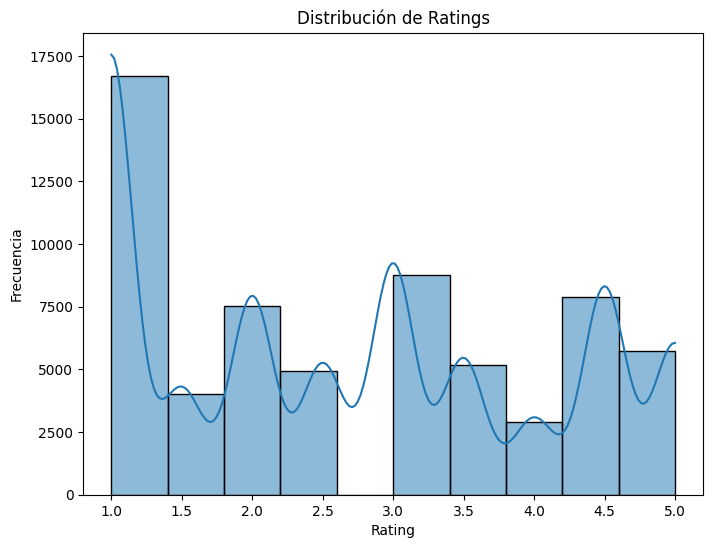

In [18]:
# Gráfico 1:  Distribucion de Ratings

########################################################################################################################

plt.figure(figsize=(8, 6))
sns.histplot(data['rating'], bins=10, kde=True)
plt.title('Distribución de Ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

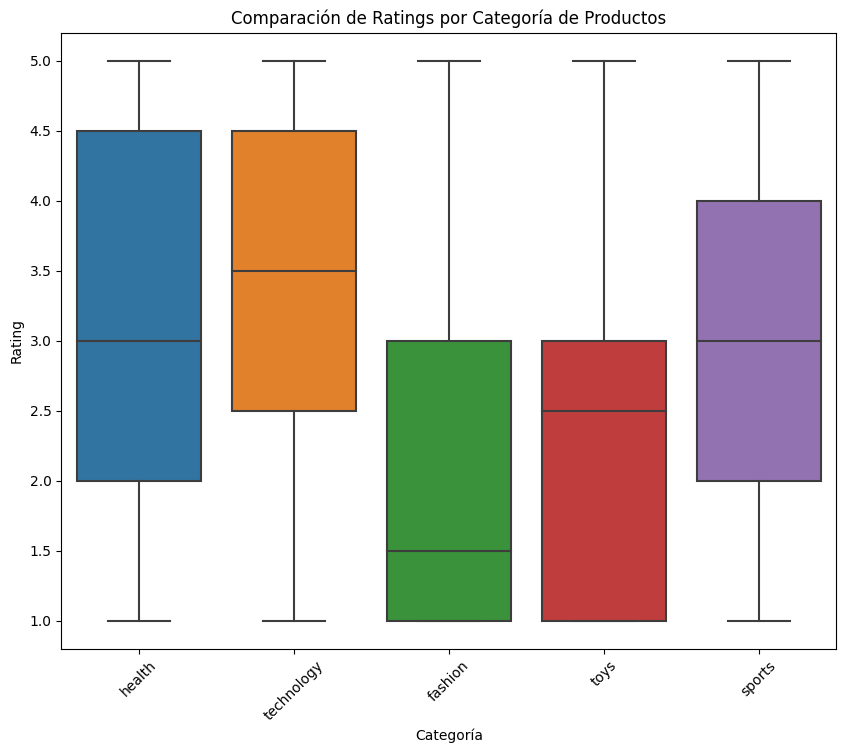

In [19]:
# Gráfico 2: Comparacion de Ratings por Categoria de Productos

########################################################################################################################

plt.figure(figsize=(10, 8))
sns.boxplot(data=data, x='category', y='rating')
plt.title('Comparación de Ratings por Categoría de Productos')
plt.xlabel('Categoría')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Modifica la lista de columnas a eliminar según consideres.

x = df.drop(
    columns=[
        # Agrega las columnas que consideres
        'order', 'product', 'seller', 'customer', 'city', 'state', 'purchased', 'delivered', 'estimated_delivery','rating', 'rating_class'
        
    ]
)

########################################################################################################################

# Esta celda se encarga de dividir los datos en conjuntos de entrenamiento, validación y prueba.

y = df['rating_class']

x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)

print(f'Train: {x_train.shape[0]} rows')
print(f'Validation: {x_val.shape[0]} rows')
print(f'Test: {x_test.shape[0]} rows')

display(x_train.head(5))

Train: 40707 rows
Validation: 10177 rows
Test: 12722 rows


,category,price,shipping,payment
12599,0,-0.490650,1.081507,0
62633,2,-0.004609,-0.385221,0
4875,1,-0.492803,-0.754221,0
59977,0,-0.553985,2.833793,0
18343,3,-0.564570,-0.122709,0


# 3. Se pueden encontrar patrones en los datos de entrenamiento. ¿Qué patrones se encuentran en los pedidos? ¿Cómo pueden ser de utilidad para mejorar las ventas de AMAZOFF?

📖 **Referencia Externa:** [Documentación de mlxtend](https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/).

---

✅ **Explicación:**

-Se prepararon los datos convirtiendo las columnas categoricas en variables binarias usando dummies para los valores 0 o 1.
-Se generan los itemsets y se aplica el metodo apriori de mlxtend en el dataframe binario expecificando el soporte minimo en (min_support) para encontrar combinaciones.
-Se generan las reglas de asociacion con association_rules sobre los items frecuentes.

In [21]:
binary_x_train = pd.get_dummies(x_train, columns=['category', 'price', 'shipping', 'payment'], drop_first=True).astype(bool)
binary_x_train.head()

,category_1,category_2,category_3,category_4,price_-0.6088862941858648,price_-0.6074509570393182,price_-0.6065718130370583,price_-0.6065538713227265,price_-0.6064821044653992,price_-0.6059259113211123,price_-0.6058362027494533,price_-0.6051185341761799,price_-0.604257331888252,price_-0.6041317398879291,price_-0.60404203131627,price_-0.6038805558872834,price_-0.603503779886315,price_-0.6033243627429966,price_-0.6033064210286648,price_-0.6032346541713375,price_-0.6031449455996784,price_-0.60296552845636,price_-0.6022478598830867,price_-0.6020863844541002,price_-0.6020684427397683,price_-0.601996675882441,price_-0.60188902559645,price_-0.6018531421677864,price_-0.601799317024791,price_-0.6017275501674636,price_-0.6016198998814726,price_-0.6015840164528089,price_-0.6014763661668179,price_-0.6014045993094905,price_-0.6011713570231767,price_-0.6010457650228539,price_-0.6004536884499034,price_-0.600292213020917,price_-0.6001127958775987,price_-0.5999513204486121,price_-0.59973601987663,price_-0.5994130690186571,price_-0.5993951273043253,price_-0.5993771855899934,price_-0.599215710161007,price_-0.599197768446675,price_-0.599108059875016,price_-0.5990542347320205,price_-0.5988748175887022,price_-0.5987671673027112,price_-0.5986595170167202,price_-0.5985518667307292,price_-0.5984980415877337,price_-0.5983186244444154,price_-0.5981212655867651,price_-0.598031557015106,price_-0.5978880233004514,price_-0.5977086061571331,price_-0.5976727227284694,price_-0.597600955871142,price_-0.5974215387278238,price_-0.5974035970134919,price_-0.5973138884418328,price_-0.5972600632988372,price_-0.5972241798701735,price_-0.5971165295841826,price_-0.5970447627268552,price_-0.5970088792981916,price_-0.596955054155196,price_-0.5968832872978688,price_-0.596865345583537,price_-0.596739753583214,price_-0.5966859284402186,price_-0.5964706278682366,price_-0.5964347444395729,price_-0.5964168027252411,price_-0.5959682598669453,price_-0.5958067844379588,price_-0.595788842723627,price_-0.595681192437636,price_-0.5956632507233042,price_-0.5956094255803086,price_-0.5953761832939948,price_-0.5951967661506765,price_-0.5951070575790173,price_-0.5950891158646855,price_-0.5949814655786945,price_-0.5949455821500308,price_-0.5949096987213671,price_-0.5948917570070353,price_-0.594712339863717,price_-0.5946405730063896,price_-0.5946046895777259,price_-0.5945508644347305,price_-0.5944970392917349,price_-0.5943535055770803,price_-0.5942637970054211,price_-0.5941382050050983,price_-0.5940126130047755,price_-0.5939946712904437,price_-0.5938152541471253,price_-0.5932949444315022,price_-0.5932770027171704,price_-0.5931872941455112,price_-0.5931155272881838,price_-0.5930258187165247,price_-0.5927566930015472,price_-0.5926669844298881,price_-0.5926131592868926,price_-0.5924696255722378,price_-0.5922902084289196,price_-0.5922184415715922,price_-0.592146674714265,price_-0.592021082713942,price_-0.5919493158566148,price_-0.5918416655706238,price_-0.591716073570301,price_-0.5915366564269826,price_-0.5914828312839872,price_-0.5913931227123279,price_-0.5913572392836642,price_-0.5913392975693325,price_-0.5912675307120051,price_-0.5911957638546778,price_-0.5910522301400232,price_-0.5910163467113594,price_-0.5909625215683639,price_-0.5908548712823729,price_-0.5908369295680411,price_-0.5907651627107138,price_-0.5906754541390545,price_-0.5904242701384089,price_-0.5904063284240771,price_-0.5903883867097454,price_-0.5903704449954135,price_-0.5901372027090996,price_-0.5900654358517723,price_-0.5900474941374405,price_-0.5899219021371177,price_-0.5898680769941221,price_-0.5897424849937993,price_-0.5896886598508039,price_-0.5895451261361492,price_-0.5893298255641671,price_-0.5891504084208489,price_-0.5889709912775305,price_-0.588917166134535,price_-0.5887018655625531,price_-0.5886659821338893,price_-0.5886300987052256,price_-0.5886121569908939,price_-0.5884506815619074,price_-0.5884147981332437,price_-0.5883968564189118,price_-0.588271264418589,price_-0.5882533227042572,price_-0.5881277307039344,price_

In [22]:
frequent_itemsets = apriori(binary_x_train, min_support=0.05, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head(10)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)
rules.sort_values(by="confidence", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


# 4. ¡Viva el ML! Toca predecir la satisfacción del cliente. ¿Es posible predecir bien el `rating_class`?

📖 **Referencia Externa:** [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

---

✅ **Explicación:**

- **Justificacion de los hiperpámetros:** 
-El hiperparametro n_estimators son el numero de valores que permite capturar los patrones sin incrementar demasiado el tiempo de entrenamiento.
-El hiperparametro max_depth es el maximo de profundidad de los arboles, para impedir que se vuelvan mas complejos.
-El hiperparametro min_samples_split es el minimo de muestras que se requieren.
-El hiperparametro max_features selecciona la raiz cuadrada de caracteristicas en cada division.
- **¿Hay *overfitting* o *underfitting*:** Es underfitting ya que la precision y el recall estan relativamente bajos.
- **Resultados de Validación:** 
-Los resultados muestran que el modelo RF1 tiene un rendimiento general de 64%
-RF2 presenta un comportamiento similar, con precision y recall equilibrados para high y low
-RF3 muestra menos precision general que puede sugerir que al modelo le faltan patrones complejos
- **Resultados de Testeo:** Muestra una precision global similar a la validacion
- **¿Es posible predecir bien el `rating_class`:** El modelo es bueno para predecir las clases high y low con un rendimiento aceptable, pero como se vio muestra dificultades para clasificar correctamente la clase medium.

In [23]:
%%time

rf1 = RandomForestClassifier(
    n_estimators=100,       # Número de árboles en el bosque
    max_depth=10,           # Profundidad máxima de cada árbol
    min_samples_split=5,    # Mínimo de muestras necesarias para dividir un nodo
    max_features='sqrt',    # Número de características a considerar en cada división
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf1.fit(x_train, y_train)

CPU times: total: 5.78 s
Wall time: 527 ms


RandomForestClassifier(max_depth=10, min_samples_split=5, n_jobs=-1,
                       random_state=0)

In [ ]:
%%time

rf2 = RandomForestClassifier(
    n_estimators=200,       # Aumentamos el número de árboles para mejorar la estabilidad
    max_depth=15,           # Mayor profundidad para capturar más detalles
    min_samples_split=10,   # Requiere más muestras para dividir, previniendo sobreajuste
    max_features='log2',    # Cambiamos a log2 para variar el conjunto de características en cada división
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf2.fit(x_train, y_train)

CPU times: total: 16.5 s
Wall time: 1.38 s


RandomForestClassifier(max_depth=15, max_features='log2', min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=0)

In [25]:
%%time

rf3 = RandomForestClassifier(
    n_estimators=50,             # Menor número de árboles para un modelo más rápido
    max_depth=5,                 # Reducción en la profundidad para simplificar el modelo
    min_samples_leaf=4,          # Mayor número mínimo de muestras por hoja
    min_samples_split=8,         # Divisiones con al menos 8 muestras para evitar sobreajuste
    max_features=None,           # Considera todas las características para reducir variabilidad
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf3.fit(x_train, y_train)

CPU times: total: 2.42 s
Wall time: 267 ms


RandomForestClassifier(max_depth=5, max_features=None, min_samples_leaf=4,
                       min_samples_split=8, n_estimators=50, n_jobs=-1,
                       random_state=0)

In [26]:
# Esta celda se encarga de evaluar los modelos y mostrar los resultados.

y_val_pred1 = rf1.predict(x_val)
y_val_pred2 = rf2.predict(x_val)
y_val_pred3 = rf3.predict(x_val)

print('[Random Forest] Check Overfitting with Accuracy')
print(f'RF1: train={accuracy_score(y_train, rf1.predict(x_train)):.4f} val={accuracy_score(y_val, y_val_pred1):.4f}')
print(f'RF2: train={accuracy_score(y_train, rf2.predict(x_train)):.4f} val={accuracy_score(y_val, y_val_pred2):.4f}')
print(f'RF3: train={accuracy_score(y_train, rf3.predict(x_train)):.4f} val={accuracy_score(y_val, y_val_pred3):.4f}')

[Random Forest] Check Overfitting with Accuracy
RF1: train=0.6697 val=0.6425
RF2: train=0.7445 val=0.6384
RF3: train=0.6366 val=0.6359


In [ ]:
# Esta celda se encarga de mostrar los resultados en el set de validación.

print('[Random Forest] Validation Classification Report')
print('#'*80)
print('RF1')
print(classification_report(y_val, y_val_pred1))
print('#'*80)
print('RF2')
print(classification_report(y_val, y_val_pred2))
print('#'*80)
print('RF3')
print(classification_report(y_val, y_val_pred3))

In [ ]:
[Random Forest] Validation Classification Report
################################################################################
RF1
              precision    recall  f1-score   support

        high       0.57      0.82      0.67      3521
         low       0.74      0.80      0.77      4490
      medium       0.25      0.03      0.05      2166

    accuracy                           0.64     10177
   macro avg       0.52      0.55      0.50     10177
weighted avg       0.58      0.64      0.58     10177

################################################################################
RF2
              precision    recall  f1-score   support

        high       0.58      0.78      0.66      3521
         low       0.75      0.79      0.77      4490
      medium       0.32      0.11      0.16      2166

    accuracy                           0.64     10177
   macro avg       0.55      0.56      0.53     10177
weighted avg       0.60      0.64      0.60     10177

################################################################################
RF3
              precision    recall  f1-score   support

        high       0.55      0.82      0.66      3521
         low       0.73      0.80      0.76      4490
      medium       0.00      0.00      0.00      2166

    accuracy                           0.64     10177
   macro avg       0.43      0.54      0.47     10177
weighted avg       0.51      0.64      0.56     10177


In [ ]:
# Esta celda se encarga de evaluar los modelos en el set de testeo y mostrar los resultados.

y_pred_rf1 = rf1.predict(x_test)
y_pred_rf2 = rf2.predict(x_test)
y_pred_rf3 = rf3.predict(x_test)

print('[Random Forest] Test Classification Report')
print('#'*80)
print('RF1')
print(classification_report(y_test, y_pred_rf1))
print('#'*80)
print('RF2')
print(classification_report(y_test, y_pred_rf2))
print('#'*80)
print('RF3')
print(classification_report(y_test, y_pred_rf3))

[Random Forest] Test Classification Report
################################################################################
RF1
              precision    recall  f1-score   support

        high       0.57      0.83      0.68      4347
         low       0.74      0.81      0.78      5653
      medium       0.37      0.04      0.07      2722

    accuracy                           0.65     12722
   macro avg       0.56      0.56      0.51     12722
weighted avg       0.61      0.65      0.59     12722

################################################################################
RF2
              precision    recall  f1-score   support

        high       0.58      0.78      0.67      4347
         low       0.75      0.80      0.77      5653
      medium       0.32      0.10      0.16      2722

    accuracy                           0.64     12722
   macro avg       0.55      0.56      0.53     12722
weighted avg       0.60      0.64      0.60     12722

################################################################################
RF3
              precision    recall  f1-score   support

        high       0.55      0.83      0.66      4347
         low       0.73      0.80      0.76      5653
      medium       0.00      0.00      0.00      2722

    accuracy                           0.64     12722
   macro avg       0.43      0.54      0.48     12722
weighted avg       0.51      0.64      0.57     12722

# 5. En  el casi de que el equipo de Customer Experience dice que un solo modelo no es suficiente. ¿Se podría implementar otro?

📖 **Referencia Externa:** [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

---

✅ **Explicación:**

- **Justificacion de los hiperpámetros:** los hiperparametros elegidos para cada modelo KNN estan ajustados para optimizar la precision y adaptarse a las caracteristicas
- **¿Hay *overfitting* o *underfitting*:** La precision en los conjuntos de entrenamiento y validacion es similar, lo que sugiere que no hay overfitting.
- **Resultados de Validación:** En el conjunto de validacion, los modelos muestran una precision promedio de alrededor del 60%.
- **Resultados de Testeo:** Los resultados en el conjunto de testeo indican que los modelos generalizan bien
- **¿Es posible predecir bien el `rating_class`:** Aunque los modelos pueden predecir razonablemente bien las clases high y low, la baja precision en la clase medium indica que el modelo no es completamente fiable para predecir rating_class

In [26]:
# Instancia tu modelo 1 aquí.

knn1 = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='minkowski')
knn1.fit(x_train, y_train)


KNeighborsClassifier()

In [27]:
# Instancia tu modelo 2 aquí.

knn2 = KNeighborsClassifier(n_neighbors=10, weights='distance', metric='minkowski')
knn2.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=10, weights='distance')

In [28]:
# Instancia tu modelo 3 aquí.

knn3 = KNeighborsClassifier(n_neighbors=7, weights='distance', metric='manhattan')
knn3.fit(x_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance')

In [31]:
# Revisar si hay overfitting (resultado de entrenamiento muy superior al de validación).
# Utilizar: `accuracy_score`.

# Calcular la precisión en el conjunto de entrenamiento y validación para cada modelo
train_acc_knn1 = accuracy_score(y_train, knn1.predict(x_train))
val_acc_knn1 = accuracy_score(y_val, knn1.predict(x_val))

train_acc_knn2 = accuracy_score(y_train, knn2.predict(x_train))
val_acc_knn2 = accuracy_score(y_val, knn2.predict(x_val))

train_acc_knn3 = accuracy_score(y_train, knn3.predict(x_train))
val_acc_knn3 = accuracy_score(y_val, knn3.predict(x_val))

# Se muestran los resultados para observar posibles signos de overfitting
print(f'KNN1 - Entrenamiento: {train_acc_knn1:.4f}, Validación: {val_acc_knn1:.4f}')
print(f'KNN2 - Entrenamiento: {train_acc_knn2:.4f}, Validación: {val_acc_knn2:.4f}')
print(f'KNN3 - Entrenamiento: {train_acc_knn3:.4f}, Validación: {val_acc_knn3:.4f}')

KNN1 - Entrenamiento: 0.7176, Validación: 0.5970
KNN2 - Entrenamiento: 0.9265, Validación: 0.5962
KNN3 - Entrenamiento: 0.9264, Validación: 0.5948


In [32]:
# Se muestran los resultados de los modelos en el set de validacion (classification_report).

# Generar las predicciones en el conjunto de validación para cada modelo
y_val_pred_knn1 = knn1.predict(x_val)
y_val_pred_knn2 = knn2.predict(x_val)
y_val_pred_knn3 = knn3.predict(x_val)

# Se muestra el reporte de clasificacion para cada modelo
print('[KNN Validation Classification Report]')
print('#'*80)
print('KNN1')
print(classification_report(y_val, y_val_pred_knn1))
print('#'*80)
print('KNN2')
print(classification_report(y_val, y_val_pred_knn2))
print('#'*80)
print('KNN3')
print(classification_report(y_val, y_val_pred_knn3))

[KNN Validation Classification Report]
################################################################################
KNN1
              precision    recall  f1-score   support

        high       0.54      0.68      0.61      3521
         low       0.72      0.75      0.74      4490
      medium       0.28      0.15      0.20      2166

    accuracy                           0.60     10177
   macro avg       0.52      0.53      0.51     10177
weighted avg       0.57      0.60      0.58     10177

################################################################################
KNN2
              precision    recall  f1-score   support

        high       0.57      0.63      0.60      3521
         low       0.72      0.75      0.74      4490
      medium       0.28      0.21      0.24      2166

    accuracy                           0.60     10177
   macro avg       0.53      0.53      0.53     10177
weighted avg       0.58      0.60      0.59     10177

###########################

In [33]:
# Se muestran los resultados de tus modelos en el set de testeo (classification_report).

# Genera las predicciones en el conjunto de testeo para cada modelo
y_test_pred_knn1 = knn1.predict(x_test)
y_test_pred_knn2 = knn2.predict(x_test)
y_test_pred_knn3 = knn3.predict(x_test)

# Se muestra el reporte de clasificacion para cada modelo en el conjunto de testeo
print('[KNN Test Classification Report]')
print('#'*80)
print('KNN1')
print(classification_report(y_test, y_test_pred_knn1))
print('#'*80)
print('KNN2')
print(classification_report(y_test, y_test_pred_knn2))
print('#'*80)
print('KNN3')
print(classification_report(y_test, y_test_pred_knn3))

[KNN Test Classification Report]
################################################################################
KNN1
              precision    recall  f1-score   support

        high       0.56      0.70      0.62      4347
         low       0.73      0.76      0.74      5653
      medium       0.30      0.16      0.20      2722

    accuracy                           0.61     12722
   macro avg       0.53      0.54      0.52     12722
weighted avg       0.58      0.61      0.59     12722

################################################################################
KNN2
              precision    recall  f1-score   support

        high       0.58      0.66      0.62      4347
         low       0.73      0.77      0.75      5653
      medium       0.31      0.22      0.26      2722

    accuracy                           0.61     12722
   macro avg       0.54      0.55      0.54     12722
weighted avg       0.59      0.61      0.60     12722

#################################

# 6. ¿Qué modelo funcionó peor? ¿PCA podría ser mejor?


📖 **Referencia Externa:** [PCA](https://www.baeldung.com/cs/pca).

---

✅ **Explicación:**

- **¿Por qué elegiste ese número de componentes?** Se seleccionaron componentes que capturen la mayor varianza de los datos sin perder demasiada informacion.
- **Resultados de Validación:** La precision en la validacion fue baja para la clase "Medium", indicando problemas con las categorias al diferenciarlas
- **Resultados de Testeo:** Similar al set de validacion, pero con mejores resultados en "Low"
- **¿Mejoraron los resultados al usar PCA? ¿Por qué?** PCA no mostro mejoras significativas. Significa que la reduccion de dimensionalidad no fue suficiente

In [ ]:
# Gráfico de Varianza Explicada por Número de Componentes

explained_variance = []
for i in range(1, 8):
    pca = PCA(n_components=i)
    pca.fit(x_train)
    explained_variance.append(pca.explained_variance_ratio_.sum())

plt.plot(range(1, 8), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

In [36]:
pca = PCA(n_components=0.95)

########################################################################################################################

# Esta celda se encarga de transformar los datos con PCA.

pca.fit(x_train)

x_train_pca = pca.transform(x_train)
x_val_pca = pca.transform(x_val)
x_test_pca = pca.transform(x_test)

In [37]:
model = KNeighborsClassifier(n_neighbors=5)

########################################################################################################################

# Este código se encarga de entrenar el modelo y mostrar los resultados en el set de validación.

model.fit(x_train_pca, y_train)

y_val_pca_pred = model.predict(x_val_pca)

print(f'[{model.__class__.__name__}] Validation Classification Report')
print(classification_report(y_val, y_val_pca_pred))

[KNeighborsClassifier] Validation Classification Report
              precision    recall  f1-score   support

        high       0.53      0.69      0.60      3521
         low       0.72      0.72      0.72      4490
      medium       0.29      0.15      0.19      2166

    accuracy                           0.59     10177
   macro avg       0.51      0.52      0.50     10177
weighted avg       0.56      0.59      0.57     10177



In [38]:
# Esta celda se encarga de mostrar los resultados en el set de test.

y_test_pca_pred = model.predict(x_test_pca)

print(f'[{model.__class__.__name__}] Test Classification Report')
print(classification_report(y_test, y_test_pca_pred))

[KNeighborsClassifier] Test Classification Report
              precision    recall  f1-score   support

        high       0.53      0.69      0.60      4347
         low       0.72      0.73      0.73      5653
      medium       0.29      0.14      0.19      2722

    accuracy                           0.59     12722
   macro avg       0.51      0.52      0.51     12722
weighted avg       0.56      0.59      0.57     12722

